# Curiosity-driven exploration with causality prior in VectorIncrement environment

Based on https://pathak22.github.io/noreward-rl/

Setting the right GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

Imports

In [24]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

from vectorincrement import *
from common import *
from curiosity import *

Environment hyperparameters

In [25]:
v_n = 2
v_k = 2
v_seed = 43
do_transform = True
time_limit = 20

Agent hyperparameters

In [26]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

Decoder: a linear transformation from observations to features

In [5]:
l2_decoder_coeff = 1e-3 # to prevent weight explosion from the l1 loss

In [6]:
# two layers, will sync parameters between them

decoder_layer = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal',
                             kernel_regularizer = tf.keras.regularizers.l2(l2_decoder_coeff))

decoder_layer_agent = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal',
                             kernel_regularizer = tf.keras.regularizers.l2(l2_decoder_coeff))

decoder = tf.keras.Sequential(
    [
        decoder_layer
    ]
)

Model of the environment

In [10]:
l1coeff = 1e-2

model_train_epochs = 10

In [11]:
env_model = tf.keras.Sequential([
    m_passthrough_action(decoder),
    tf.keras.layers.InputLayer(input_shape=(v_k + v_n,)), # input: [state, one-hot action]
    tf.keras.layers.Dense(v_k, kernel_regularizer=tf.keras.regularizers.l1(l1coeff)) # output: state
])

env_model.compile('adam', 'mse')

Curiosity parameters

In [12]:
alpha = 1.0

curiosity_interval = 20

Creating a curiosity-wrapped environment

In [13]:
def get_env(add_curiosity_reward=True):
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    if add_curiosity_reward:
        env = CuriosityWrapper(env, env_model, alpha=alpha)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [14]:
train_env = get_env(add_curiosity_reward=True)
eval_env = get_env(add_curiosity_reward=False)

In [15]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu,
    preprocessing_layers=decoder_layer_agent
    # for features: add preprocessing_layers=[...]
)

In [16]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [17]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [18]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [19]:
curiosity_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000) # should never overflow

In [20]:
decoder_layer_agent = actor_net.layers[0].layers[0] # taking the copied layer with actual weights

Agent train step
DECODER:[[-0.0697959  -0.00308524]
 [-0.00708889  0.04244918]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06977716 -0.00313098]
 [-0.00706076  0.0423805 ]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06972814 -0.00325062]
 [-0.00688241  0.04194515]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06972394 -0.00326089]
 [-0.00687853  0.04193568]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.0598

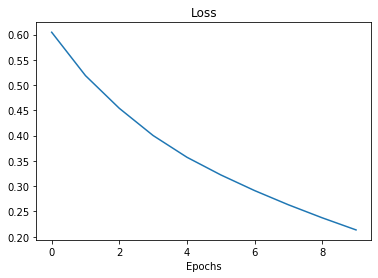

Model train step
DECODER:[[0.479818   0.41022664]
 [0.56586415 0.47023848]]
MODEL:[array([[-7.8320831e-05,  4.7681406e-01],
       [ 1.5621202e-04,  5.6602437e-02],
       [-1.4667749e-01, -2.5055325e-01],
       [-5.0274849e-01, -1.3829523e-01]], dtype=float32), array([ 0.15457374, -0.12645833], dtype=float32)]
Agent train step
DECODER:[[0.4798     0.41027063]
 [0.5658133  0.4703627 ]]
MODEL:[array([[-7.8320831e-05,  4.7681406e-01],
       [ 1.5621202e-04,  5.6602437e-02],
       [-1.4667749e-01, -2.5055325e-01],
       [-5.0274849e-01, -1.3829523e-01]], dtype=float32), array([ 0.15457374, -0.12645833], dtype=float32)]
Agent train step
DECODER:[[0.47973818 0.41042224]
 [0.56570804 0.47062084]]
MODEL:[array([[-7.8320831e-05,  4.7681406e-01],
       [ 1.5621202e-04,  5.6602437e-02],
       [-1.4667749e-01, -2.5055325e-01],
       [-5.0274849e-01, -1.3829523e-01]], dtype=float32), array([ 0.15457374, -0.12645833], dtype=float32)]
Agent train step
DECODER:[[0.47976393 0.4103585 ]
 [0.5659

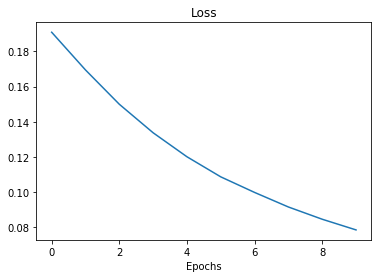

Model train step
DECODER:[[0.81324804 0.3188551 ]
 [0.9405997  0.44885847]]
MODEL:[array([[ 1.2383984e-04,  2.4451527e-01],
       [ 7.8076904e-05,  4.2926046e-04],
       [-3.6909012e-04, -1.4007876e-04],
       [-1.2830977e-01,  2.4098047e-04]], dtype=float32), array([-0.11172252, -0.40387696], dtype=float32)]
Agent train step
DECODER:[[0.8132391  0.31887668]
 [0.94057024 0.44892967]]
MODEL:[array([[ 1.2383984e-04,  2.4451527e-01],
       [ 7.8076904e-05,  4.2926046e-04],
       [-3.6909012e-04, -1.4007876e-04],
       [-1.2830977e-01,  2.4098047e-04]], dtype=float32), array([-0.11172252, -0.40387696], dtype=float32)]
Agent train step
DECODER:[[0.81327873 0.3187805 ]
 [0.9406557  0.4487224 ]]
MODEL:[array([[ 1.2383984e-04,  2.4451527e-01],
       [ 7.8076904e-05,  4.2926046e-04],
       [-3.6909012e-04, -1.4007876e-04],
       [-1.2830977e-01,  2.4098047e-04]], dtype=float32), array([-0.11172252, -0.40387696], dtype=float32)]
Agent train step
DECODER:[[0.81326437 0.31881502]
 [0.9405

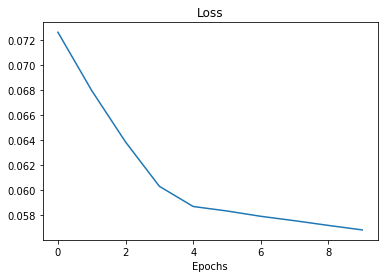

Model train step
DECODER:[[0.98325825 0.20522773]
 [1.1963016  0.40145734]]
MODEL:[array([[ 4.0846918e-04,  2.0607172e-01],
       [ 1.7339899e-04,  2.4883228e-04],
       [ 2.3419026e-04, -9.5031202e-05],
       [-1.1653577e-04,  8.2709827e-05]], dtype=float32), array([-0.19859831, -0.40344217], dtype=float32)]
Agent train step
DECODER:[[0.98323244 0.20528913]
 [1.1962231  0.401644  ]]
MODEL:[array([[ 4.0846918e-04,  2.0607172e-01],
       [ 1.7339899e-04,  2.4883228e-04],
       [ 2.3419026e-04, -9.5031202e-05],
       [-1.1653577e-04,  8.2709827e-05]], dtype=float32), array([-0.19859831, -0.40344217], dtype=float32)]
Agent train step
DECODER:[[0.9832312  0.20529215]
 [1.1962278  0.4016327 ]]
MODEL:[array([[ 4.0846918e-04,  2.0607172e-01],
       [ 1.7339899e-04,  2.4883228e-04],
       [ 2.3419026e-04, -9.5031202e-05],
       [-1.1653577e-04,  8.2709827e-05]], dtype=float32), array([-0.19859831, -0.40344217], dtype=float32)]
Agent train step
DECODER:[[0.98327297 0.20519172]
 [1.1964

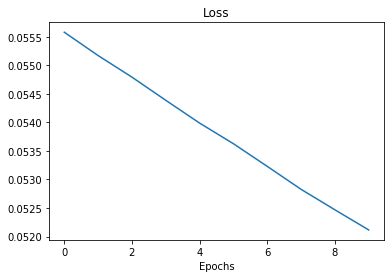

Model train step
DECODER:[[1.1435208  0.10870345]
 [1.4828541  0.3408218 ]]
MODEL:[array([[ 1.6252391e-04,  2.3546903e-01],
       [-7.7496552e-05, -7.6454351e-05],
       [ 8.6425382e-05, -1.6495891e-04],
       [-2.3964043e-05, -1.4989154e-04]], dtype=float32), array([-0.19169769, -0.34895167], dtype=float32)]
Agent train step
DECODER:[[1.1435337  0.10867407]
 [1.4829404  0.34062475]]
MODEL:[array([[ 1.6252391e-04,  2.3546903e-01],
       [-7.7496552e-05, -7.6454351e-05],
       [ 8.6425382e-05, -1.6495891e-04],
       [-2.3964043e-05, -1.4989154e-04]], dtype=float32), array([-0.19169769, -0.34895167], dtype=float32)]
Agent train step
DECODER:[[1.1434926  0.10876689]
 [1.4828345  0.34086418]]
MODEL:[array([[ 1.6252391e-04,  2.3546903e-01],
       [-7.7496552e-05, -7.6454351e-05],
       [ 8.6425382e-05, -1.6495891e-04],
       [-2.3964043e-05, -1.4989154e-04]], dtype=float32), array([-0.19169769, -0.34895167], dtype=float32)]
Agent train step
DECODER:[[1.143519   0.10870601]
 [1.4829

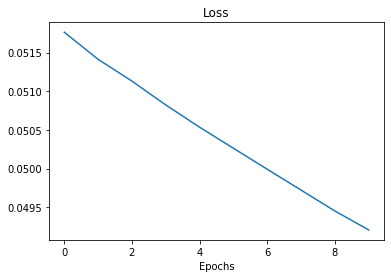

Model train step
DECODER:[[1.2444627  0.04455293]
 [1.7698678  0.27125147]]
MODEL:[array([[-1.2642104e-04,  2.3715205e-01],
       [-1.3039069e-04,  4.9387636e-05],
       [-2.2148964e-04, -2.5726942e-05],
       [ 7.9173857e-05,  3.4196582e-05]], dtype=float32), array([-0.19924761, -0.2991266 ], dtype=float32)]
Agent train step
DECODER:[[1.2444283  0.04463136]
 [1.7697538  0.27151117]]
MODEL:[array([[-1.2642104e-04,  2.3715205e-01],
       [-1.3039069e-04,  4.9387636e-05],
       [-2.2148964e-04, -2.5726942e-05],
       [ 7.9173857e-05,  3.4196582e-05]], dtype=float32), array([-0.19924761, -0.2991266 ], dtype=float32)]
Agent train step
DECODER:[[1.2444425  0.04459832]
 [1.7697624  0.27149117]]
MODEL:[array([[-1.2642104e-04,  2.3715205e-01],
       [-1.3039069e-04,  4.9387636e-05],
       [-2.2148964e-04, -2.5726942e-05],
       [ 7.9173857e-05,  3.4196582e-05]], dtype=float32), array([-0.19924761, -0.2991266 ], dtype=float32)]
Agent train step
DECODER:[[1.2443444  0.0448254 ]
 [1.7695

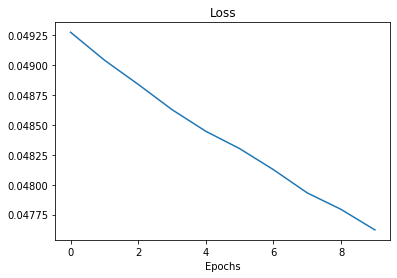

Model train step
DECODER:[[1.2627454  0.01290096]
 [2.0361412  0.19758207]]
MODEL:[array([[ 5.5609772e-04,  2.2676614e-01],
       [ 6.5727741e-05, -1.8893335e-04],
       [-7.0230075e-05,  6.5163229e-05],
       [-1.0366454e-04,  8.6330438e-05]], dtype=float32), array([-0.20653751, -0.2682122 ], dtype=float32)]
Agent train step
DECODER:[[1.2627561  0.01287652]
 [2.0362034  0.19744124]]
MODEL:[array([[ 5.5609772e-04,  2.2676614e-01],
       [ 6.5727741e-05, -1.8893335e-04],
       [-7.0230075e-05,  6.5163229e-05],
       [-1.0366454e-04,  8.6330438e-05]], dtype=float32), array([-0.20653751, -0.2682122 ], dtype=float32)]
Agent train step
DECODER:[[1.262728   0.01293969]
 [2.036164   0.19752938]]
MODEL:[array([[ 5.5609772e-04,  2.2676614e-01],
       [ 6.5727741e-05, -1.8893335e-04],
       [-7.0230075e-05,  6.5163229e-05],
       [-1.0366454e-04,  8.6330438e-05]], dtype=float32), array([-0.20653751, -0.2682122 ], dtype=float32)]
Agent train step
DECODER:[[1.26274    0.01291239]
 [2.0361

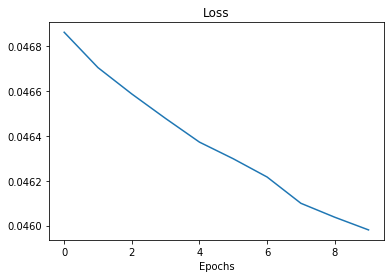

Model train step
DECODER:[[1.2586088  0.00245615]
 [2.2555559  0.12864035]]
MODEL:[array([[ 1.6493513e-04,  2.1361212e-01],
       [ 1.2915576e-04, -1.8226664e-04],
       [-1.2337751e-04, -1.7939191e-04],
       [ 1.3678044e-04,  1.5189237e-04]], dtype=float32), array([-0.2191945 , -0.25207835], dtype=float32)]
Agent train step
DECODER:[[1.258526   0.00267226]
 [2.2553961  0.12905732]]
MODEL:[array([[ 1.6493513e-04,  2.1361212e-01],
       [ 1.2915576e-04, -1.8226664e-04],
       [-1.2337751e-04, -1.7939191e-04],
       [ 1.3678044e-04,  1.5189237e-04]], dtype=float32), array([-0.2191945 , -0.25207835], dtype=float32)]
Agent train step
DECODER:[[1.2585107  0.00271381]
 [2.255339   0.12921338]]
MODEL:[array([[ 1.6493513e-04,  2.1361212e-01],
       [ 1.2915576e-04, -1.8226664e-04],
       [-1.2337751e-04, -1.7939191e-04],
       [ 1.3678044e-04,  1.5189237e-04]], dtype=float32), array([-0.2191945 , -0.25207835], dtype=float32)]
Agent train step
DECODER:[[1.2585123  0.00270938]
 [2.2553

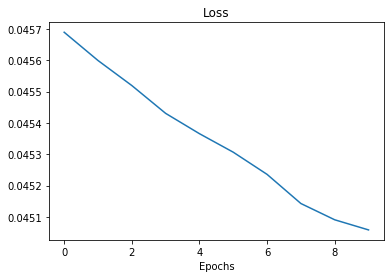

Model train step
DECODER:[[1.2003880e+00 3.7472104e-04]
 [2.4735212e+00 7.1946457e-02]]
MODEL:[array([[ 2.8834259e-03,  2.1346241e-01],
       [-6.5972672e-05,  5.3177224e-05],
       [-4.5000255e-05,  1.2922920e-04],
       [-5.6997131e-05, -2.2668726e-04]], dtype=float32), array([-0.21160807, -0.23340109], dtype=float32)]
Agent train step
DECODER:[[1.2003828e+00 3.9235147e-04]
 [2.4734766e+00 7.2098948e-02]]
MODEL:[array([[ 2.8834259e-03,  2.1346241e-01],
       [-6.5972672e-05,  5.3177224e-05],
       [-4.5000255e-05,  1.2922920e-04],
       [-5.6997131e-05, -2.2668726e-04]], dtype=float32), array([-0.21160807, -0.23340109], dtype=float32)]
Agent train step
DECODER:[[1.2003244e+00 5.9610512e-04]
 [2.4733953e+00 7.2381906e-02]]
MODEL:[array([[ 2.8834259e-03,  2.1346241e-01],
       [-6.5972672e-05,  5.3177224e-05],
       [-4.5000255e-05,  1.2922920e-04],
       [-5.6997131e-05, -2.2668726e-04]], dtype=float32), array([-0.21160807, -0.23340109], dtype=float32)]
Agent train step
DECOD

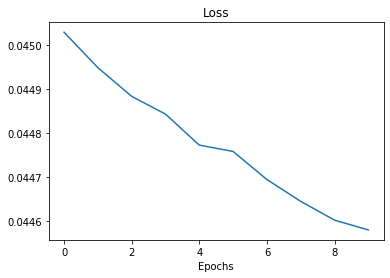

Model train step
DECODER:[[1.0943415e+00 1.6809357e-04]
 [2.6782651e+00 3.2428339e-02]]
MODEL:[array([[ 3.0457242e-03,  2.1452083e-01],
       [ 3.2309676e-05,  3.7300997e-04],
       [ 9.6888805e-05, -9.2517686e-05],
       [-2.5141257e-05,  1.1181592e-04]], dtype=float32), array([-0.2043001 , -0.22254962], dtype=float32)]
Agent train step
DECODER:[[1.0943271e+00 2.3505854e-04]
 [2.6782298e+00 3.2592408e-02]]
MODEL:[array([[ 3.0457242e-03,  2.1452083e-01],
       [ 3.2309676e-05,  3.7300997e-04],
       [ 9.6888805e-05, -9.2517686e-05],
       [-2.5141257e-05,  1.1181592e-04]], dtype=float32), array([-0.2043001 , -0.22254962], dtype=float32)]
Agent train step
DECODER:[[1.0943283e+00 2.2959888e-04]
 [2.6782439e+00 3.2525089e-02]]
MODEL:[array([[ 3.0457242e-03,  2.1452083e-01],
       [ 3.2309676e-05,  3.7300997e-04],
       [ 9.6888805e-05, -9.2517686e-05],
       [-2.5141257e-05,  1.1181592e-04]], dtype=float32), array([-0.2043001 , -0.22254962], dtype=float32)]
Agent train step
DECOD

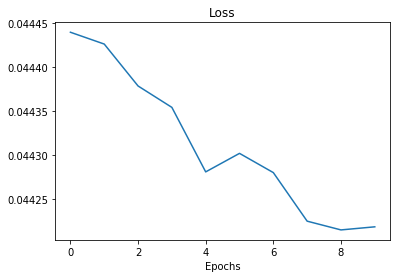

Model train step
DECODER:[[1.0023077e+00 2.3451119e-06]
 [2.8463719e+00 1.0519811e-02]]
MODEL:[array([[ 2.9768560e-03,  2.1421985e-01],
       [ 4.9012531e-05, -2.8413089e-04],
       [ 1.6722795e-04,  2.1310338e-04],
       [ 2.9012772e-06,  1.7260345e-04]], dtype=float32), array([-0.19909965, -0.21589531], dtype=float32)]
Agent train step
DECODER:[[ 1.0023106e+00 -1.3351289e-05]
 [ 2.8463802e+00  1.0475256e-02]]
MODEL:[array([[ 2.9768560e-03,  2.1421985e-01],
       [ 4.9012531e-05, -2.8413089e-04],
       [ 1.6722795e-04,  2.1310338e-04],
       [ 2.9012772e-06,  1.7260345e-04]], dtype=float32), array([-0.19909965, -0.21589531], dtype=float32)]
Agent train step
DECODER:[[1.0023053e+00 1.4511672e-05]
 [2.8463447e+00 1.0661038e-02]]
MODEL:[array([[ 2.9768560e-03,  2.1421985e-01],
       [ 4.9012531e-05, -2.8413089e-04],
       [ 1.6722795e-04,  2.1310338e-04],
       [ 2.9012772e-06,  1.7260345e-04]], dtype=float32), array([-0.19909965, -0.21589531], dtype=float32)]
Agent train step
D

KeyboardInterrupt: 

In [21]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]
curiosity_loss = []

def print_weights():
    """Show weights."""
    print("DECODER:" + str(decoder_layer_agent.get_weights()[0]))
    print("MODEL:" + str(env_model.layers[2].get_weights()))

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(train_env, tf_agent.collect_policy,
                  collect_episodes_per_iteration,
                  [replay_buffer,curiosity_replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()
    
  print("Agent train step")
  print_weights()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(train_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train curiosity Average return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)
    
  if step % curiosity_interval == 0:
    xs, ys = buffer_to_dataset(curiosity_replay_buffer)
    
    # setting weights from the agent to the model...
    decoder_layer.set_weights(decoder_layer_agent.get_weights())
    history = env_model.fit(xs, ys, epochs=model_train_epochs, verbose=0)
    
    # setting weights from the model to the agent...
    decoder_layer_agent.set_weights(decoder_layer.get_weights())
    
    plt.title("Loss")
    plt.plot(history.history['loss'])
    curiosity_loss += list(history.history['loss'])
    plt.xlabel("Epochs")
    plt.show()
    curiosity_replay_buffer.clear()
    
    print("Model train step")
    print_weights()

In [ ]:
plt.title("Curiosity loss")
plt.plot(curiosity_loss)
plt.show()

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
fig = plt.figure()
fig.patch.set_facecolor('lightgreen')
plt.title("Returns with added curiosity reward in training")
plt.plot(steps, returns, label="eval")
plt.plot(steps, train_returns, label="train")
plt.ylabel('Average Return')
plt.legend()
plt.xlabel('Step')

Evaluating the model

In [ ]:
curiosity_replay_buffer.clear()
collect_episode(eval_env, tf_agent.collect_policy, 25, [curiosity_replay_buffer])
collect_episode(eval_env, tf_agent.policy, 25, [curiosity_replay_buffer])
xs, ys = buffer_to_dataset(curiosity_replay_buffer)
env_model.evaluate(xs, ys)

In [ ]:
xs